In this notebook, we will try to train an LSTM model using API-Calls from android applications.

<h1>Loading Data</h1>

<h1>Regular Run Start</h1>
Up from here, you can find the necessary code to prepare the data to train using API-Calls.
For convenience, here on out we will use the already exported data.

In [37]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import joblib
from tensorflow.keras.utils import to_categorical


# Read the CSV file
df = pd.read_csv('./api_calls_labeled_dataset.csv')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df['detection'].value_counts()

detection
trojan        7793
adware        4545
benign        4296
other          766
hacktool       261
spyware        255
exploit        222
rootkit         43
ransomware       5
Name: count, dtype: int64

In [38]:
df = df[~df['detection'].isin(['ransomware', 'rootkit', 'other'])]

benign_samples = df[df['detection'] == 'benign'].sample(n=1000, random_state=42)
trojan_samples = df[df['detection'] == 'trojan'].sample(n=400, random_state=42)
adware_samples = df[df['detection'] == 'adware'].sample(n=300, random_state=42)
other_samples = df[~df['detection'].isin(['benign', 'trojan', 'adware'])].groupby('detection').apply(lambda x: x.sample(n=200, random_state=42)).reset_index(drop=True)

df = pd.concat([benign_samples, other_samples, trojan_samples, adware_samples]).reset_index(drop=True)
df['detection'].value_counts()


/tmp/ipykernel_7044/3879448589.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  other_samples = df[~df['detection'].isin(['benign', 'trojan', 'adware'])].groupby('detection').apply(lambda x: x.sample(n=200, random_state=42)).reset_index(drop=True)


detection
benign      1000
trojan       400
adware       300
exploit      200
hacktool     200
spyware      200
Name: count, dtype: int64

In [42]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import joblib
from tensorflow.keras.utils import to_categorical

df = pd.read_csv('./fine-tuned_models/lstm/catch_o_ware_data-api-call.csv')

df['detection'].value_counts()



detection
benign      1000
trojan       400
adware       300
exploit      200
hacktool     200
spyware      200
Name: count, dtype: int64

In [39]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
labels = label_encoder.fit_transform(df['detection'])

# Tokenize the API call sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['api_calls'])

# Convert sequences to numerical representations
sequences = tokenizer.texts_to_sequences(df['api_calls'])

# Define the maximum sequence length
max_seq_length = 500

# Pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

categorical_labels = to_categorical(labels)


<h1> Save the label_encoder and tokenizer </h1>

In [42]:
# Fit and transform the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['detection'])

# Tokenize the API call sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['api_calls'])

# Save the label encoder and tokenizer
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(tokenizer, 'tokenizer.pkl')


['tokenizer.pkl']

<h1> Load them  </h1>

In [43]:
import joblib

# Load the label encoder and tokenizer
label_encoder = joblib.load('./Models/lstm-model/label_encoder.pkl')
tokenizer = joblib.load('./Models/lstm-model/tokenizer.pkl')

# Transform the labels and sequences using the loaded encoders
labels = label_encoder.transform(df['detection'])
sequences = tokenizer.texts_to_sequences(df['api_calls'])

# Define the maximum sequence length and pad the sequences
max_seq_length = 500
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

categorical_labels = to_categorical(labels)


<h1>Training LSTM</h1>

In [44]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, categorical_labels, test_size=0.2, random_state=42, stratify=categorical_labels)
print("Validation set shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)


Validation set shape: (460, 500)
Training labels shape: (1840, 6)
Validation labels shape: (460, 6)


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.regularizers import l2

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64))

model.add(LSTM(96, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))

model.add(LSTM(32, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))

model.add(Dense(len(label_encoder.classes_), activation='softmax'))


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
import tensorflow as tf
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[
    #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
])


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.3729 - loss: 3.6016 - val_accuracy: 0.4348 - val_loss: 2.7107 - learning_rate: 0.0010
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.4493 - loss: 2.5252 - val_accuracy: 0.5152 - val_loss: 1.8861 - learning_rate: 0.0010
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.5890 - loss: 1.7125 - val_accuracy: 0.5522 - val_loss: 1.7513 - learning_rate: 0.0010
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.6372 - loss: 1.4156 - val_accuracy: 0.6674 - val_loss: 1.1254 - learning_rate: 0.0010
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7379 - loss: 0.9884 - val_accuracy: 0.6978 - val_loss: 0.9936 - learning_rate: 0.0010
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.7707 - loss: 0.8363 - val_accuracy: 0.6761 - val_loss: 0.9975 - learning_rate: 0.0010
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.7645 - loss: 0.7684 - val_acc

<h1> Fine-Tune </h1>

<h3> Create trojan model </h3>

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Read the CSV file
df = pd.read_csv('api_calls_labeled_dataset.csv')

# Set 'detection' to 'non-trojan' for all rows where it's not 'trojan'
df.loc[df['detection'] != 'trojan', 'detection'] = 'non-trojan'

# Initialize the binary labels
labels = (df['detection'] == 'trojan').astype(int)

# Tokenize the API call sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['api_calls'])

# Convert sequences to numerical representations
sequences = tokenizer.texts_to_sequences(df['api_calls'])

# Define the maximum sequence length
max_seq_length = 500

# Pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train_trojan, X_val_trojan, y_train_trojan, y_val_trojan = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42, stratify=labels)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import joblib
from tensorflow.keras.utils import to_categorical


# Read the CSV file
df = pd.read_csv('api_calls_labeled_dataset.csv')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df = df[df['detection'] != 'ransomware']
df = df[df['detection'] != 'rootkit']
df = df[df['detection'] != 'other']
df = df[df['detection'] != 'trojan']

benign_samples = df[df['detection'] == 'benign'].sample(n=1000, replace=True, random_state=42)
other_samples = df[df['detection'] != 'benign'].groupby('detection').apply(lambda x: x.sample(n=200, replace=True, random_state=42)).reset_index(drop=True)
df = pd.concat([benign_samples, other_samples]).reset_index(drop=True)
print(df['detection'].value_counts())

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
labels = label_encoder.fit_transform(df['detection'])

# Tokenize the API call sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['api_calls'])

# Convert sequences to numerical representations
sequences = tokenizer.texts_to_sequences(df['api_calls'])

# Define the maximum sequence length
max_seq_length = 500

# Pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

categorical_labels = to_categorical(labels)

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train_class_5, X_val_class_5, y_train_class_5, y_val_class_5 = train_test_split(padded_sequences, categorical_labels, test_size=0.2, random_state=42, stratify=categorical_labels)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2

# Input layer
input_layer = Input(shape=(max_seq_length,))

# Shared embedding layer
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64)(input_layer)

# First LSTM branch for 5-class classification
lstm_branch1 = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))(embedding_layer)
lstm_branch1 = Dropout(0.3)(lstm_branch1)
lstm_branch1 = LSTM(16, kernel_regularizer=l2(0.01))(lstm_branch1)
lstm_branch1 = Dropout(0.3)(lstm_branch1)
output1 = Dense(5, activation='softmax', name='class_5')(lstm_branch1)

# Second LSTM branch for binary classification (e.g., trojan vs. non-trojan)
lstm_branch2 = LSTM(8, return_sequences=True, kernel_regularizer=l2(0.01))(embedding_layer)
lstm_branch2 = Dropout(0.25)(lstm_branch2)
lstm_branch2 = LSTM(4, kernel_regularizer=l2(0.01))(lstm_branch2)
lstm_branch2 = Dropout(0.5)(lstm_branch2)
output2 = Dense(1, activation='sigmoid', name='class_trojan')(lstm_branch2)

# Combine the two branches into a single model
model = Model(inputs=input_layer, outputs=[output1, output2])

# Compile the model with different losses and metrics for each output
model.compile(optimizer='adam',
              loss={'class_5': 'categorical_crossentropy', 'class_trojan': 'binary_crossentropy'},
              metrics={'class_5': 'accuracy', 'class_trojan': 'accuracy'})

model.summary()


<h3> Train model </h3>

<h1>K-Fold Cross Validation</h1>

In [45]:
from sklearn.model_selection import KFold
from keras.models import load_model

# Initialize KFold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store metrics for each fold
fold_accuracies = []
fold_losses = []

for train_index, val_index in kf.split(padded_sequences):
    X_train, X_val = padded_sequences[train_index], padded_sequences[val_index]
    y_train, y_val = categorical_labels[train_index], categorical_labels[val_index]
    
    # Load the pre-trained LSTM model
    model = load_model('./fine-tuned_models/lstm/lstm_api-call_balanced.keras')

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_crossentropy', 'accuracy'])
    
    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
    
    # Evaluate the model on the validation set
    results = model.evaluate(X_val, y_val)
    print(f"Fold results: {results}")
    loss = results[1]
    accuracy = results[2]

    fold_accuracies.append(accuracy)
    fold_losses.append(loss)    
    print(f"Fold validation accuracy: {accuracy}")
    print(f"Fold validation loss: {loss}")

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - accuracy: 0.4297 - categorical_crossentropy: 1.8836 - loss: 1.9301 - val_accuracy: 0.5043 - val_categorical_crossentropy: 1.2703 - val_loss: 1.3073
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.5631 - categorical_crossentropy: 1.1900 - loss: 1.2274 - val_accuracy: 0.6522 - val_categorical_crossentropy: 0.9439 - val_loss: 0.9855
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.6707 - categorical_crossentropy: 0.9053 - loss: 0.9491 - val_accuracy: 0.6957 - val_categorical_crossentropy: 0.8086 - val_loss: 0.8547
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.7767 - categorical_crossentropy: 0.6436 - loss: 0.6901 - val_accuracy: 0.7130 - val_categorical_crossentropy: 0.7852 - val_loss: 0.8351
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.8172 - categorical_crossentropy: 0.5096 - loss: 0.5598 - val_accuracy: 0.7609 - val_categorical_crossentropy: 0.6930 - val_loss

In [31]:
# Calculate the average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
average_loss = np.mean(fold_losses)
print(f"Average validation accuracy: {average_accuracy}")
print(f"Average validation loss: {average_loss}")

Average validation accuracy: 0.9221739053726197
Average validation loss: 0.2988212168216705


<h1> Load saved model </h1>

In [2]:
from keras.models import load_model
import tensorflow as tf

# Load the pre-trained LSTM model
model = load_model('./fine-tuned_models/lstm/lstm_api-call_balanced.keras')

# Display model information
model.summary()

# Print model configuration
print(model.get_config())

# Clone the model
cloned_model = tf.keras.models.clone_model(model)
cloned_model.set_weights(model.get_weights())

# Compile the cloned model
cloned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 500, 64)        │     5,734,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 500, 96)        │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 500, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,440,532 (66.53 MB)

 Trainable params: 5,813,510 (22.18 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,627,022 (44.35 MB)

{'name': 'sequential_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 500), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_3'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Embedding', 'config': {'name': 'embedding_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'input_dim': 89609, 'output_dim': 64, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}, 'registered_name': None}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 500]}}, {'module': 'keras.layers',

In [ ]:
# Continue training the cloned model
history = cloned_model.fit(
    X_train, 
    y_train, 
    epochs=10,  # You can adjust the number of epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2),
        tf.keras.callbacks.ModelCheckpoint(
            filepath='cloned_model.keras',
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        )
    ]
)

# Evaluate the cloned model
test_loss, test_accuracy = cloned_model.evaluate(X_val, y_val)
print(f"Test accuracy of cloned model: {test_accuracy:.4f}")

# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Generate predictions using the cloned model
y_pred = cloned_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Generate and print the classification report
from sklearn.metrics import classification_report
print("Classification Report for Cloned Model:")
print(classification_report(y_true, y_pred_classes))


<h1> Evaluate the model </h1>

In [36]:
from sklearn.metrics import classification_report

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Predict on the validation set
y_pred_probs = model.predict(X_val)
y_pred = np.zeros_like(y_pred_probs)
y_pred[np.arange(len(y_pred_probs)), y_pred_probs.argmax(axis=1)] = 1

# Generate a classification report
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))




Validation Loss: 0.5153690576553345
Validation Accuracy: 0.895652174949646
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Classification Report:
              precision    recall  f1-score   support

      adware       0.82      0.83      0.83        60
      benign       0.96      0.93      0.94       200
     exploit       0.81      0.88      0.84        40
    hacktool       0.94      0.85      0.89        40
     spyware       0.76      0.85      0.80        40
      trojan       0.90      0.93      0.91        80

   micro avg       0.90      0.90      0.90       460
   macro avg       0.87      0.88      0.87       460
weighted avg       0.90      0.90      0.90       460
 samples avg       0.90      0.90      0.90       460



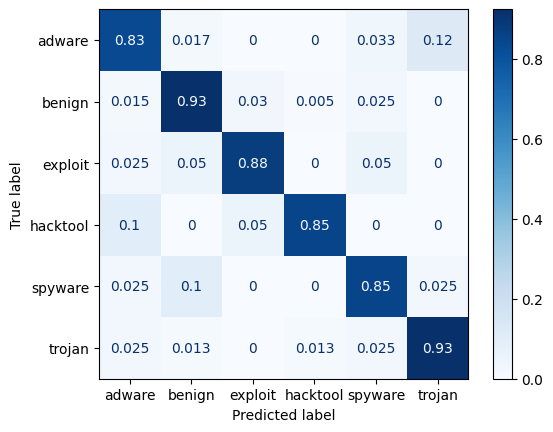

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure y_true and y_pred are in class index format
y_true = np.argmax(y_val, axis=1)  # Convert one-hot encoded labels to class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert predicted probabilities to class indices


# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')



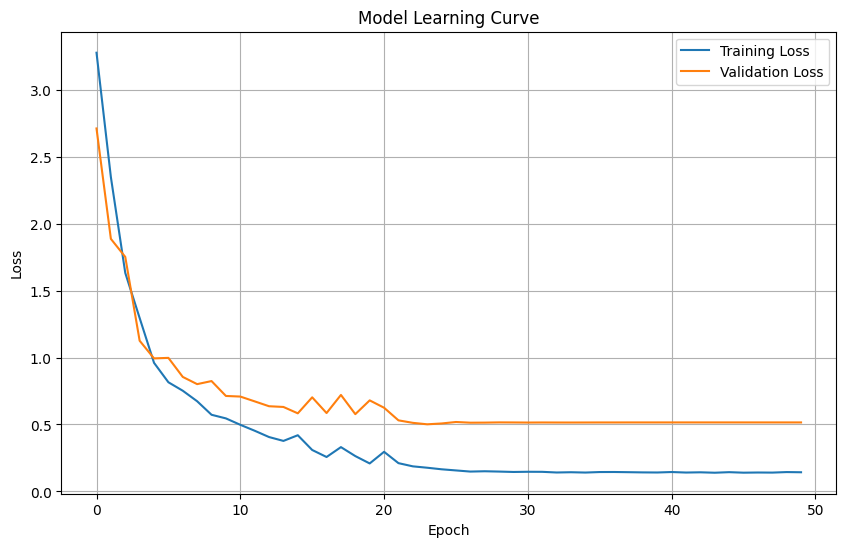

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


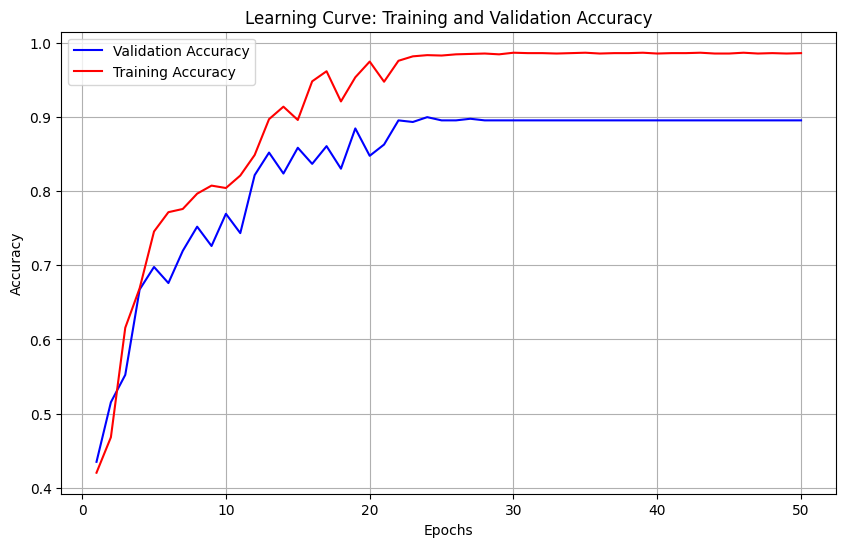

In [39]:
# Extract validation and training accuracy from history
val_accuracy = history.history['val_accuracy']
train_accuracy = history.history['accuracy']
epochs = range(1, len(val_accuracy) + 1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracy, 'b-', label='Validation Accuracy')
plt.plot(epochs, train_accuracy, 'r-', label='Training Accuracy')
plt.title('Learning Curve: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [41]:
model.save('lstm_api-call_balanced.keras')